<a href="https://colab.research.google.com/github/Krishnakanth834/MLProject1/blob/main/stock_price_predict_decisstion_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for RELIANCE.NS...


/tmp/ipython-input-1608206231.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d", progress=False)



Data Splits (Chronological):
Train Set: 700 samples (Earliest data)
Valid Set: 234 samples (Middle data)
Test Set:  234 samples (Latest data)

--- Starting Parameter Tuning (Training -> Validation) ---

🔍 Tuning Decision Tree...
   Best Decision Tree MAE: 4.57%
   Best Params: {'max_depth': 3, 'min_samples_leaf': 20, 'random_state': 42}

🔍 Tuning Random Forest...
   Best Random Forest MAE: 4.69%
   Best Params: {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 10, 'random_state': 42}

🔍 Tuning XGBoost...
   Best XGBoost MAE: 4.35%
   Best Params: {'n_estimators': 50, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8, 'random_state': 42}
----------------------------------------
🏆 ULTIMATE WINNER: XGBoost
   Validation MAE: 4.35%

--- Final Test on Unseen Data (Test Set) ---
Final Test MAE: 4.53%
Train MAE: 4.57% (For overfitting check)
✅  Success: The model generalized well.


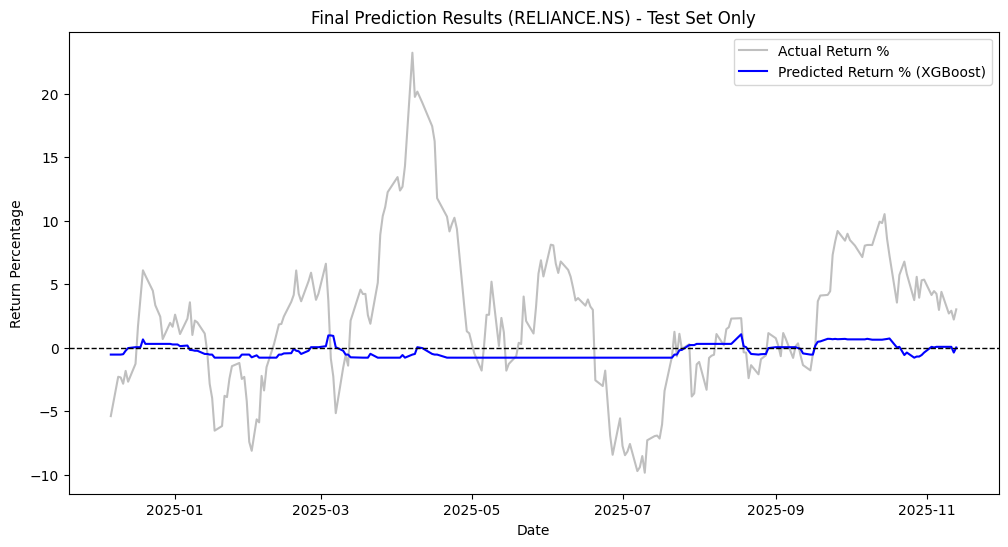

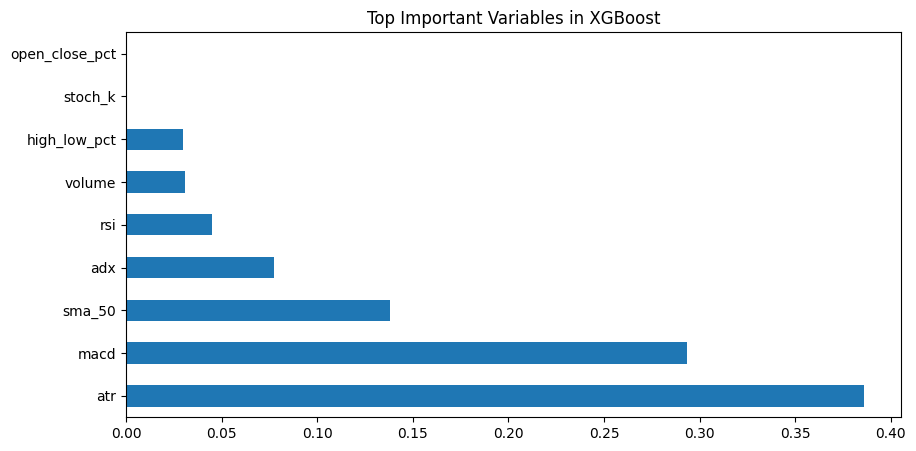

In [4]:
!pip install ta
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ==========================================
# 1. Data Fetching & Cleaning
# ==========================================
ticker = 'RELIANCE.NS'
print(f"Fetching data for {ticker}...")
df = yf.download(ticker, period="5y", interval="1d", progress=False)

# Handle MultiIndex if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# REQUIREMENT: Convert all columns to lower case
df.columns = df.columns.str.lower()

# ==========================================
# 2. Feature Engineering (Using 'ta' library)
# ==========================================
# 1. Momentum
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['stoch_k'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close']).stoch()

# 2. Trend
df['macd'] = ta.trend.MACD(df['close']).macd()
df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close']).adx()
df['sma_50'] = ta.trend.SMAIndicator(df['close'], window=50).sma_indicator()

# 3. Volatility
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()

# 4. Price Action / Shape (Ratios)
df['high_low_pct'] = (df['high'] - df['low']) / df['close']
df['open_close_pct'] = (df['open'] - df['close'].shift(1)) / df['close'].shift(1)

# ==========================================
# 3. Target Creation (Percentage Return)
# ==========================================
# Prediction Goal: Return % in next 21 days (approx 1 month)
df['target'] = (df['close'].shift(-21) - df['close']) / df['close'] * 100

# Drop NaNs created by indicators and shifting
df.dropna(inplace=True)

# Define Features and Target
feature_cols = ['rsi', 'stoch_k', 'macd', 'adx', 'sma_50', 'atr', 'high_low_pct', 'open_close_pct', 'volume']
X = df[feature_cols]
y = df['target']

# ==========================================
# 4. Splitting: 60% Train, 20% Val, 20% Test
# ==========================================
# IMPORTANT: shuffle=False is critical for Stock Data (Time Series)

# Step 1: Split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split Temp (40%) into Validation (20%) and Test (20%)
# Since 20% is half of 40%, we split Temp by 0.5
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"\nData Splits (Chronological):")
print(f"Train Set: {len(X_train)} samples (Earliest data)")
print(f"Valid Set: {len(X_val)} samples (Middle data)")
print(f"Test Set:  {len(X_test)} samples (Latest data)")

from itertools import product

# ==========================================
# 5. Automated Parameter Tuning (Grid Search)
# ==========================================
# We define a "grid" of parameters to try for each model
param_grids = {
    "Decision Tree": {
        "model_class": DecisionTreeRegressor,
        "params": {
            "max_depth": [3, 5, 7, 10],
            "min_samples_leaf": [10, 20, 50],
            "random_state": [42]
        }
    },
    "Random Forest": {
        "model_class": RandomForestRegressor,
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [10, 20],
            "random_state": [42]
        }
    },
    "XGBoost": {
        "model_class": XGBRegressor,
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8],
            "random_state": [42]
        }
    }
}

best_overall_model = None
best_overall_name = ""
best_overall_mae = float('inf')

print("\n--- Starting Parameter Tuning (Training -> Validation) ---")

for model_name, config in param_grids.items():
    print(f"\n🔍 Tuning {model_name}...")
    model_class = config["model_class"]
    param_dict = config["params"]

    # Generate all combinations of parameters
    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    best_model_for_type = None
    best_mae_for_type = float('inf')
    best_params_for_type = {}

    # Loop through every combination
    for params in param_combinations:
        # 1. Create model with these specific params
        temp_model = model_class(**params)

        # 2. Train on 60% Training Data
        temp_model.fit(X_train, y_train)

        # 3. Predict on 20% Validation Data
        val_pred = temp_model.predict(X_val)
        val_mae = mean_absolute_error(y_val, val_pred)

        # 4. Compare
        if val_mae < best_mae_for_type:
            best_mae_for_type = val_mae
            best_model_for_type = temp_model
            best_params_for_type = params

    print(f"   Best {model_name} MAE: {best_mae_for_type:.2f}%")
    print(f"   Best Params: {best_params_for_type}")

    # Check if this is the global winner
    if best_mae_for_type < best_overall_mae:
        best_overall_mae = best_mae_for_type
        best_overall_model = best_model_for_type
        best_overall_name = model_name

print("-" * 40)
print(f"🏆 ULTIMATE WINNER: {best_overall_name}")
print(f"   Validation MAE: {best_overall_mae:.2f}%")

# ==========================================
# 6. Final Test (Unseen Data)
# ==========================================
print(f"\n--- Final Test on Unseen Data (Test Set) ---")
# Use the tuned, best overall model
final_pred = best_overall_model.predict(X_test)
final_test_mae = mean_absolute_error(y_test, final_pred)

print(f"Final Test MAE: {final_test_mae:.2f}%")

# Check for Overfitting on the final model
train_mae_final = mean_absolute_error(y_train, best_overall_model.predict(X_train))
print(f"Train MAE: {train_mae_final:.2f}% (For overfitting check)")

if final_test_mae > best_overall_mae + 1.0:
    print("⚠️  Warning: The model performance dropped significantly on the Test set.")
else:
    print("✅  Success: The model generalized well.")

# ==========================================
# 7. Visualization
# ==========================================
plt.figure(figsize=(12, 6))

# Plot only Test data for clarity
plt.plot(y_test.index, y_test, label='Actual Return %', color='grey', alpha=0.5)
plt.plot(y_test.index, final_pred, label=f'Predicted Return % ({best_overall_name})', color='blue', linewidth=1.5)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title(f"Final Prediction Results ({ticker}) - Test Set Only")
plt.xlabel("Date")
plt.ylabel("Return Percentage")
plt.legend()
plt.show()

# Feature Importance
if hasattr(best_overall_model, 'feature_importances_'):
    plt.figure(figsize=(10, 5))
    feat_importances = pd.Series(best_overall_model.feature_importances_, index=feature_cols)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title(f"Top Important Variables in {best_overall_name}")
    plt.show()